# AIFFEL LMS Exploration 6 Project

## 6-9. 프로젝트 : 주식 예측에 도전해 보자


ARIMA를 통해 시계열 데이터를 예측하는 과정을 진행해 보았습니다. 이제 실제 주식값 예측에 도전해 봅시다. 데이터는 과거의 일자별 시세이며, 다음의 그림과 같이 https://finance.yahoo.com/에서 아래 그림을 따라하시면 다운로드 할 수 있습니다.


우선 대한민국 대장주 삼성전자에 대한 주식 시세를 예측해 봅시다. 이를 위해서 "samsung"을 검색하시고, "Historical Data" 탭에서 "Time Period"를 "Max"로 선택, "Apply" 버튼을 눌러 과거 삼성전자가 상장한 시점부터 가장 최근까지의 자료를 조회합니다. 그리고 "Download"를 클릭하면 데이터를 다운로드를 할 수 있습니다. 다운로드가 완료되었다면 대략 다음과 같이 작업 디렉토리로 파일을 옮겨 주세요. 실습환경에 따라 원본(source)과 사본(destination) 경로는 달라질 수 있습니다.

$ mv ~/다운로드/005930.KS.csv ~/aiffel/stock_prediction/data


이후 순서는 다음과 같습니다. 필요한 내용은 이미 앞에서 다 다루었기 때문에 이후 과정은 여러분들이 직접 수행해 보시기를 바랍니다.

# STEP 1 : 시계열 데이터 준비

칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume

날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만, 우리는 Close만 사용하겠습니다. 

(주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [206]:
# 패키지 호출
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [207]:
# 데이터 불어오기

# 파일 경로 저장
data_path_samsung = os.getenv("HOME") + "/aiffel/stock_prediction/data/samsung_electronics.csv"

# train.csv 파일을 DataFrame에 저장
# 'Date'열을 index로 변환시킴
# parse_dates=True : str자료형으로 저장된 날짜 데이터를 pandas의 
#    <class 'pandas._libs.tslibs.timestamps.Timestamp'> 자료형으로 변환
df_samsung = pd.read_csv(data_path_samsung, index_col='Date', parse_dates=True)
df_samsung.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,0.090599,74195000.0
2000-01-05,5800.0,6060.0,5520.0,5580.0,0.082740,74680000.0
2000-01-06,5750.0,5780.0,5580.0,5620.0,0.083333,54390000.0
2000-01-07,5560.0,5670.0,5360.0,5540.0,0.082147,40305000.0
2000-01-10,5600.0,5770.0,5580.0,5770.0,0.085558,46880000.0


In [208]:
# # parse_dates=True 기능 확인용 코드

# print(type(df_samsung.index[0]))
# print(type(df_samsung['Open'][0]))

In [209]:
# parse_dates=True 기능 확인용 코드

# # 데이터 불어오기

# # 파일 경로 저장
# data_path_samsung = os.getenv("HOME") + "/aiffel/stock_prediction/data/samsung_electronics.csv"

# # train.csv 파일을 DataFrame에 저장
# # 'Date'열을 index로 변환시킴

# df_samsung = pd.read_csv(data_path_samsung, index_col='Date')
# df_samsung.head()

In [210]:
# parse_dates=True 기능 확인용 코드

# print(type(df_samsung.index[0]))
# print(type(df_samsung['Open'][0]))

In [211]:
# parse_dates=True 기능 확인용 코드

# df_samsung['Date'][0]

In [212]:
# parse_dates=True 기능 확인용 코드

# type(df_samsung['Date'][0])

In [213]:
# Close(종가)만 따로 데이터 분리

df_samsung_Close = df_samsung['Close']
df_samsung_Close.head()

Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행
     * 결측치 처리
     * 로그 변환

In [214]:
# 결측치 확인 함수 출력 값 확인
# df_samsung_Close.isna()

In [215]:
# type(df_samsung_Close)

In [216]:
df_samsung_Close

Date
2000-01-04     6110.0
2000-01-05     5580.0
2000-01-06     5620.0
2000-01-07     5540.0
2000-01-10     5770.0
               ...   
2020-08-10    57800.0
2020-08-11    58200.0
2020-08-12    59000.0
2020-08-13    58700.0
2020-08-14    57900.0
Name: Close, Length: 5188, dtype: float64

In [217]:
df_samsung_Close.isna()

Date
2000-01-04    False
2000-01-05    False
2000-01-06    False
2000-01-07    False
2000-01-10    False
              ...  
2020-08-10    False
2020-08-11    False
2020-08-12    False
2020-08-13    False
2020-08-14    False
Name: Close, Length: 5188, dtype: bool

In [218]:
# 결측치 처리
# Series[] 대괄호 안에 요소가 T/F로 이루어진 같은 크기의 serise를 넣으면, 
# True에 해당하는 요소 값 출력

df_samsung_Close=df_samsung_Close.interpolate(method='time')
# .interpolate(method='time') 위에 시계

df_samsung_Close[df_samsung_Close.isna()]   # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.
# interpolation 을 수행해서 결과로 NaN이 나오지 않음


Series([], Name: Close, dtype: float64)

In [219]:
# 로그 변환 시도

df_samsung_Close_log = np.log(df_samsung_Close)

# STEP 3 : 시계열 안정성 분석

 - 정성적 그래프 분석
 - 정량적 Augmented Dicky-Fuller Test
 - 시계열 분해(Time Series Decomposition)
 - Residual 안정성 확인



In [220]:
from statsmodels.tsa.stattools import adfuller

# 정성적 그래프 함수 선언
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

# 정량적 Augmented Dicky-Fuller Test 함수 선언    
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    

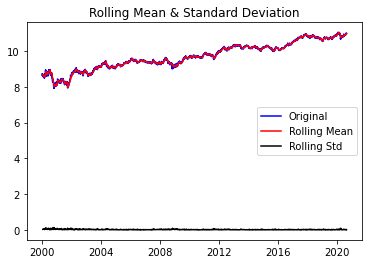

Results of Dickey-Fuller Test:
Test Statistic                   -0.700665
p-value                           0.846577
#Lags Used                        4.000000
Number of Observations Used    5183.000000
Critical Value (1%)              -3.431612
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


In [221]:
# 정성적 그래프 분석
plot_rolling_statistics(df_samsung_Close_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(df_samsung_Close_log)

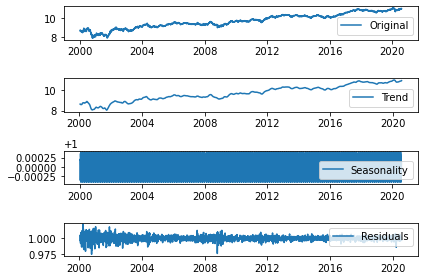

In [222]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_samsung_Close_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_samsung_Close_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

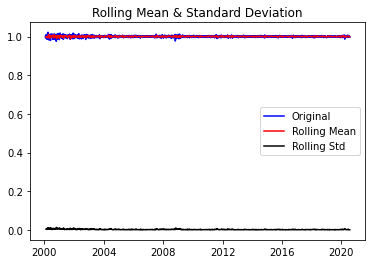

Results of Dickey-Fuller Test:
Test Statistic                -1.728618e+01
p-value                        5.741788e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.124000e+03
Critical Value (1%)           -3.431627e+00
Critical Value (5%)           -2.862104e+00
Critical Value (10%)          -2.567070e+00
dtype: float64


In [223]:
# Residual의 안정성 여부 확인

plot_rolling_statistics(residual)

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

 => p-value 값이 매우 작으므로 시계열 데이터가 안정적이라고 할 수 있음

# STEP 4 : 학습, 테스트 데이터셋 생성

     * 학습, 테스트 데이터셋 분리

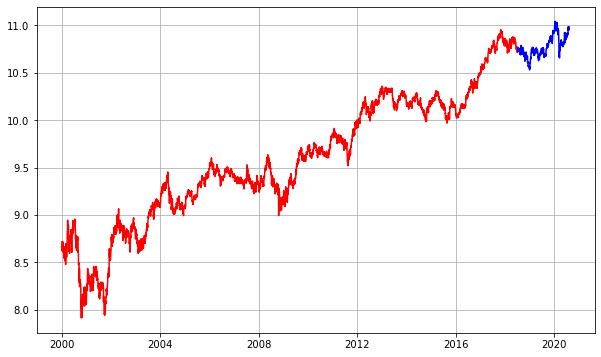

In [224]:
# 학습 데이터와 테스트 데이터 셋 분리

# 이후 Step에서 ARIMA를 사용하여 Trend와 Seasonality와 Residual로 Decompose를 수행할 것이므로
# 위에서 구한 Residual을 사용하지 않음

train_data, test_data = df_samsung_Close_log[:int(len(df_samsung_Close_log)*0.9)], df_samsung_Close_log[int(len(df_samsung_Close_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')

# STEP 5 : 적정 ARIMA 모수 찾기

 * ACF, PACF 그려보기 -> p,q 구하기
 * 차분 안정성 확인 -> d 구하기

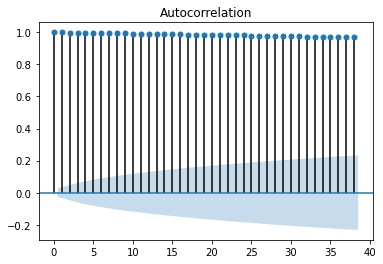

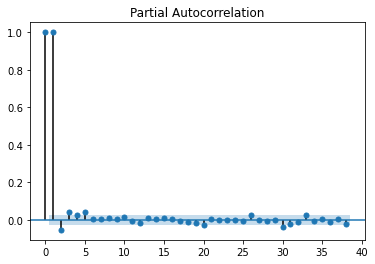

In [225]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF, PACF 그려보기
plot_acf(df_samsung_Close_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(df_samsung_Close_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -39.824276
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5183.000000
Critical Value (1%)              -3.431612
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


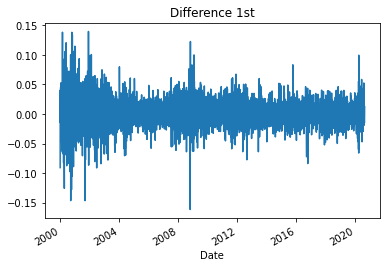

In [226]:
# 1차 차분 구하기
diff_1 = df_samsung_Close_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                  -21.585373
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5152.000000
Critical Value (1%)              -3.431620
Critical Value (5%)              -2.862101
Critical Value (10%)             -2.567069
dtype: float64


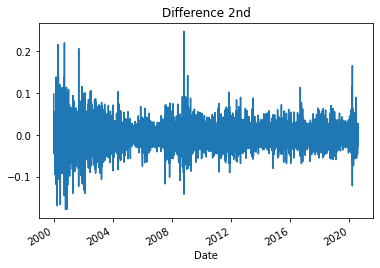

In [227]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

=> 1차, 2차 차분 모두 p-value가 0값 이므로 d=1로 선정

# STEP 6 : ARIMA 모델 훈련과 테스트
 * ARIMA 모델 빌드와 훈련
 * 모델 테스트 및 플로팅
 * 최종 예측 모델 정확도 측정(MAPE)

In [228]:
ARIMA??

In [229]:
from statsmodels.tsa.arima_model import ARIMA

# 모델 만들기
model = ARIMA(train_data, order=(1, 1, 0))  

# 모델 훈련
fitted_m = model.fit(disp=-1)  

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4668
Model:                 ARIMA(1, 1, 0)   Log Likelihood               10985.891
Method:                       css-mle   S.D. of innovations              0.023
Date:                Fri, 14 Aug 2020   AIC                         -21965.782
Time:                        18:08:59   BIC                         -21946.437
Sample:                             1   HQIC                        -21958.978
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.216      0.224      -0.000       0.001
ar.L1.D.Close     0.0476      0.015      3.252      0.001       0.019       0.076
                                    Root

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [230]:
model.fit??

질문 1. model.fit(disp=-1) 에서 disp=-1이 의미하는 것??

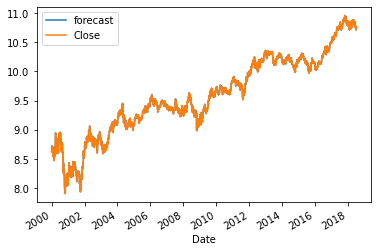

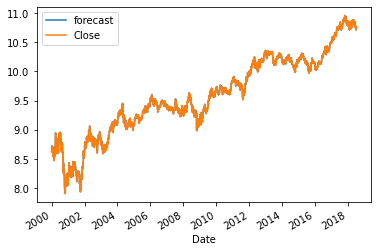

In [231]:
fitted_m.plot_predict()

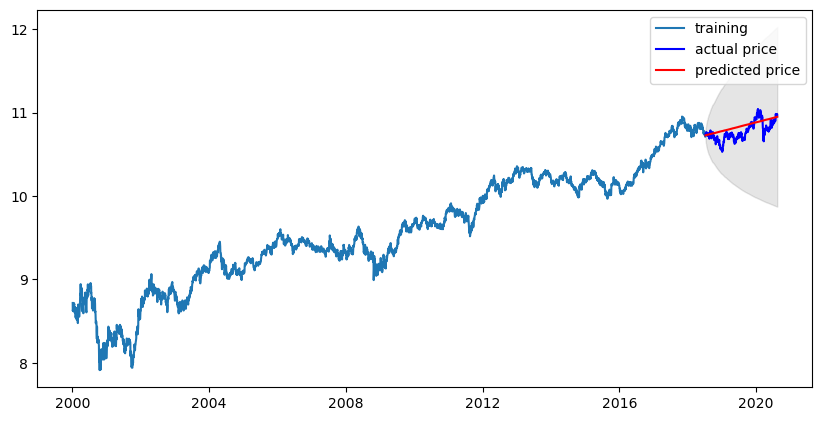

In [232]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [233]:
# 최종 예측 정확도 측정

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22976387.699319948
MAE:  4063.7769729001043
RMSE:  4793.3691386455885
MAPE: 8.77%


최종 MAPE는 8.77%로 비교적 예측이 잘 나왔다고 할 수 있음

# STEP 7 : 다른 주식 종목 예측해 보기
    
     * 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

이번에는 미국의 종합주가지수인 나스닥을 추총하는 ETF인 QQQ에 대하여 예측을 해보겠습니다.

# STEP 7 - step(1) 데이터 불러오기(종목 1 : QQQ)

In [234]:
# 데이터 불어오기

# 파일 경로 저장
data_path_QQQ = os.getenv("HOME") + "/aiffel/stock_prediction/data/QQQ.csv"

# train.csv 파일을 DataFrame에 저장
# 'Date'열을 index로 변환시킴
# parse_dates=True : str자료형으로 저장된 날짜 데이터를 pandas의 
#    <class 'pandas._libs.tslibs.timestamps.Timestamp'> 자료형으로 변환
df_QQQ = pd.read_csv(data_path_QQQ, index_col='Date', parse_dates=True)
df_QQQ.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-03-10,51.12500,51.156250,50.28125,51.0625,44.523476,5232000
1999-03-11,51.43750,51.734375,50.31250,51.3125,44.741455,9688600
1999-03-12,51.12500,51.156250,49.65625,50.0625,43.651520,8743600
1999-03-15,50.43750,51.562500,49.90625,51.5000,44.904942,6369000
1999-03-16,51.71875,52.156250,51.15625,51.9375,45.286419,4905800


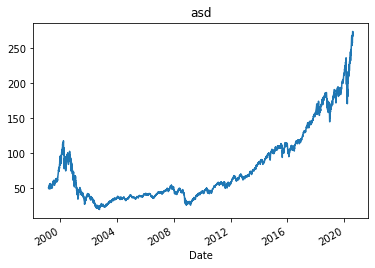

In [235]:
df_QQQ.Open.plot(title = 'asd')

In [236]:
# Close(종가)만 따로 데이터 분리

df_QQQ_Close = df_QQQ['Close']
df_QQQ_Close.head()

Date
1999-03-10    51.0625
1999-03-11    51.3125
1999-03-12    50.0625
1999-03-15    51.5000
1999-03-16    51.9375
Name: Close, dtype: float64

# STEP 7 - STEP (2) : 각종 전처리 수행(종목1 : QQQ)
     * 결측치 처리
     * 로그 변환

In [237]:
df_QQQ_Close

Date
1999-03-10     51.062500
1999-03-11     51.312500
1999-03-12     50.062500
1999-03-15     51.500000
1999-03-16     51.937500
                 ...    
2020-08-07    271.470001
2020-08-10    270.309998
2020-08-11    265.190002
2020-08-12    271.859985
2020-08-13    272.480011
Name: Close, Length: 5394, dtype: float64

In [238]:
df_QQQ_Close.isna()

Date
1999-03-10    False
1999-03-11    False
1999-03-12    False
1999-03-15    False
1999-03-16    False
              ...  
2020-08-07    False
2020-08-10    False
2020-08-11    False
2020-08-12    False
2020-08-13    False
Name: Close, Length: 5394, dtype: bool

In [239]:
# 결측치 처리
# Series[] 대괄호 안에 요소가 T/F로 이루어진 같은 크기의 serise를 넣으면, 
# True에 해당하는 요소 값 출력

df_QQQ_Close=df_QQQ_Close.interpolate(method='time')
# .interpolate(method='time') 위에 시계

df_QQQ_Close[df_QQQ_Close.isna()]   # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.
# interpolation 을 수행해서 결과로 NaN이 나오지 않음


Series([], Name: Close, dtype: float64)

In [240]:
# 로그 변환 시도

df_QQQ_Close_log = np.log(df_QQQ_Close)

# STEP 7 - STEP (3) : 시계열 안정성 분석(종목1 : QQQ)

 - 정성적 그래프 분석
 - 정량적 Augmented Dicky-Fuller Test
 - 시계열 분해(Time Series Decomposition)
 - Residual 안정성 확인



In [241]:
from statsmodels.tsa.stattools import adfuller

# 정성적 그래프 함수 선언
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

# 정량적 Augmented Dicky-Fuller Test 함수 선언    
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    

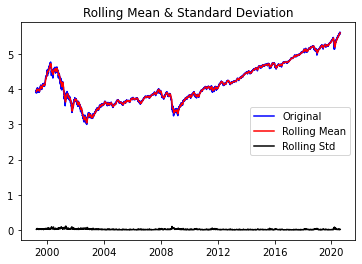

Results of Dickey-Fuller Test:
Test Statistic                    0.468142
p-value                           0.983872
#Lags Used                       18.000000
Number of Observations Used    5375.000000
Critical Value (1%)              -3.431567
Critical Value (5%)              -2.862078
Critical Value (10%)             -2.567056
dtype: float64


In [242]:
# 정성적 그래프 분석
plot_rolling_statistics(df_QQQ_Close_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(df_QQQ_Close_log)

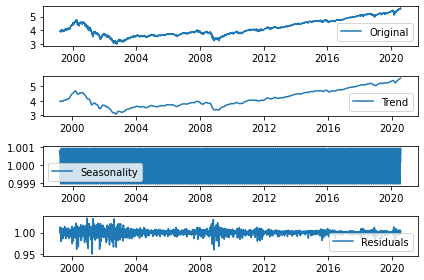

In [243]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_QQQ_Close_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_QQQ_Close_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

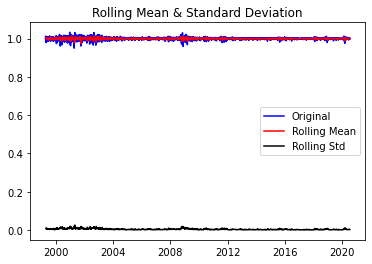

Results of Dickey-Fuller Test:
Test Statistic                -1.842583e+01
p-value                        2.172558e-30
#Lags Used                     3.200000e+01
Number of Observations Used    5.331000e+03
Critical Value (1%)           -3.431577e+00
Critical Value (5%)           -2.862082e+00
Critical Value (10%)          -2.567059e+00
dtype: float64


In [244]:
# Residual의 안정성 여부 확인

plot_rolling_statistics(residual)

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

 => p-value 값이 매우 작으므로 시계열 데이터가 안정적이라고 할 수 있음

# STEP 7 - STEP (4) : 학습, 테스트 데이터셋 생성(종목1 : QQQ)

     * 학습, 테스트 데이터셋 분리

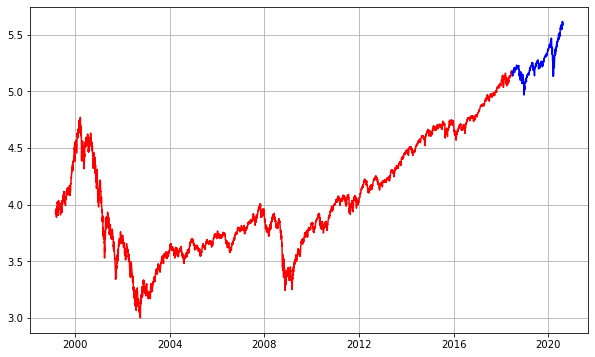

In [245]:
# 학습 데이터와 테스트 데이터 셋 분리

# 이후 Step에서 ARIMA를 사용하여 Trend와 Seasonality와 Residual로 Decompose를 수행할 것이므로
# 위에서 구한 Residual을 사용하지 않음

train_data, test_data = df_QQQ_Close_log[:int(len(df_QQQ_Close_log)*0.9)], df_QQQ_Close_log[int(len(df_QQQ_Close_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')

# STEP 7 - STEP (5) : 적정 ARIMA 모수 찾기(종목1 : QQQ)

 * ACF, PACF 그려보기 -> p,q 구하기
 * 차분 안정성 확인 -> d 구하기

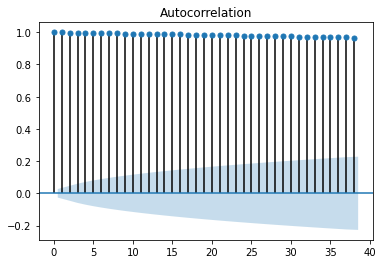

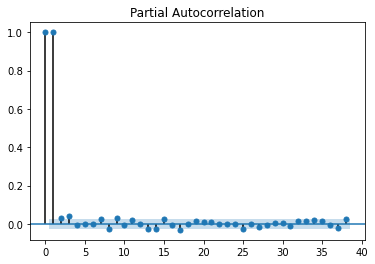

In [246]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF, PACF 그려보기
plot_acf(df_QQQ_Close_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(df_QQQ_Close_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.252685e+01
p-value                        2.477794e-23
#Lags Used                     3.300000e+01
Number of Observations Used    5.359000e+03
Critical Value (1%)           -3.431571e+00
Critical Value (5%)           -2.862079e+00
Critical Value (10%)          -2.567057e+00
dtype: float64


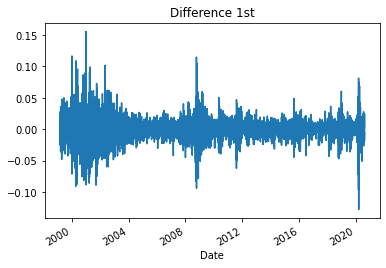

In [247]:
# 1차 차분 구하기
diff_1 = df_QQQ_Close_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                  -20.791073
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5358.000000
Critical Value (1%)              -3.431571
Critical Value (5%)              -2.862080
Critical Value (10%)             -2.567057
dtype: float64


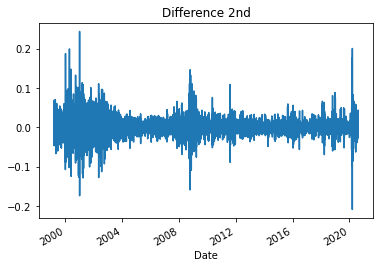

In [248]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

=> 1차, 2차 차분 모두 p-value가 0값 이므로 d=1로 선정

# STEP 7 - STEP (6) : ARIMA 모델 훈련과 테스트(종목1 : QQQ)
 * ARIMA 모델 빌드와 훈련
 * 모델 테스트 및 플로팅
 * 최종 예측 모델 정확도 측정(MAPE)

In [249]:
ARIMA??

In [250]:
from statsmodels.tsa.arima_model import ARIMA

# 모델 만들기
model = ARIMA(train_data, order=(1, 1, 0))  

# 모델 훈련
fitted_m = model.fit(disp=-1)  

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4853
Model:                 ARIMA(1, 1, 0)   Log Likelihood               12710.952
Method:                       css-mle   S.D. of innovations              0.018
Date:                Fri, 14 Aug 2020   AIC                         -25415.905
Time:                        18:09:01   BIC                         -25396.443
Sample:                             1   HQIC                        -25409.074
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.000      1.042      0.297      -0.000       0.001
ar.L1.D.Close    -0.0357      0.014     -2.489      0.013      -0.064      -0.008
                                    Root

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


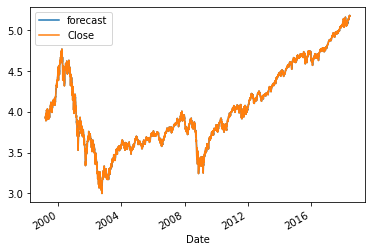

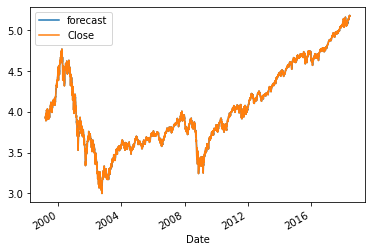

In [251]:
fitted_m.plot_predict()

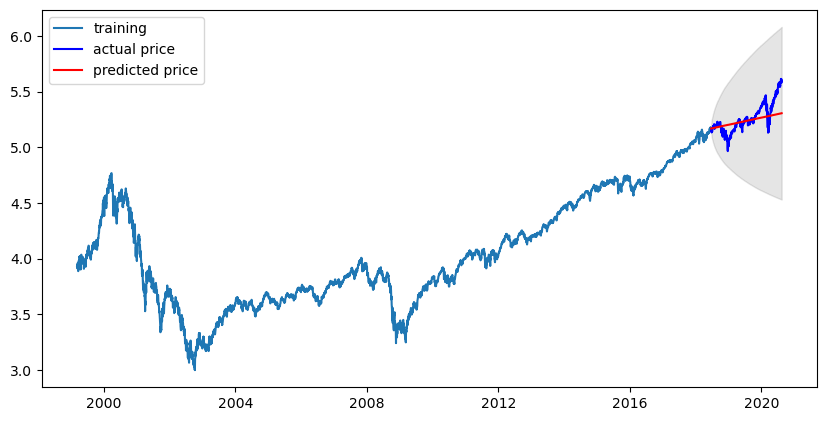

In [252]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [253]:
# 최종 예측 정확도 측정

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  479.2196737617099
MAE:  14.91942747638784
RMSE:  21.891086628162384
MAPE: 7.12%


# STEP 7 - step(1) 데이터 불러오기(종목 2 : TQQQ)

In [254]:
# 데이터 불어오기

# 파일 경로 저장
data_path_TQQQ = os.getenv("HOME") + "/aiffel/stock_prediction/data/TQQQ.csv"

# train.csv 파일을 DataFrame에 저장
# 'Date'열을 index로 변환시킴
# parse_dates=True : str자료형으로 저장된 날짜 데이터를 pandas의 
#    <class 'pandas._libs.tslibs.timestamps.Timestamp'> 자료형으로 변환
df_TQQQ = pd.read_csv(data_path_TQQQ, index_col='Date', parse_dates=True)
df_TQQQ.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-02-11,1.627500,1.739583,1.622292,1.730208,1.725885,864000
2010-02-12,1.683125,1.752292,1.673333,1.737292,1.732951,2150400
2010-02-16,1.778125,1.808750,1.750208,1.804583,1.800074,2404800
2010-02-17,1.828750,1.835625,1.801250,1.835208,1.830623,4795200
2010-02-18,1.833333,1.881042,1.822292,1.870000,1.865327,9715200


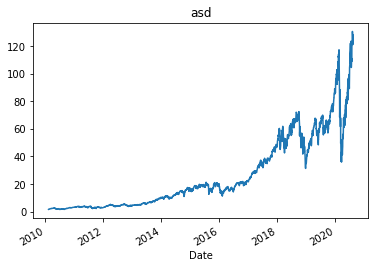

In [255]:
df_TQQQ.Open.plot(title = 'asd')

In [256]:
# Close(종가)만 따로 데이터 분리

df_TQQQ_Close = df_TQQQ['Close']
df_TQQQ_Close.head()

Date
2010-02-11    1.730208
2010-02-12    1.737292
2010-02-16    1.804583
2010-02-17    1.835208
2010-02-18    1.870000
Name: Close, dtype: float64

# STEP 7 - STEP (2) : 각종 전처리 수행(종목 2 : TQQQ)
     * 결측치 처리
     * 로그 변환

In [257]:
df_TQQQ_Close

Date
2010-02-11      1.730208
2010-02-12      1.737292
2010-02-16      1.804583
2010-02-17      1.835208
2010-02-18      1.870000
                 ...    
2020-08-07    126.989998
2020-08-10    125.279999
2020-08-11    118.169998
2020-08-12    127.010002
2020-08-13    127.900002
Name: Close, Length: 2645, dtype: float64

In [258]:
df_TQQQ_Close.isna()

Date
2010-02-11    False
2010-02-12    False
2010-02-16    False
2010-02-17    False
2010-02-18    False
              ...  
2020-08-07    False
2020-08-10    False
2020-08-11    False
2020-08-12    False
2020-08-13    False
Name: Close, Length: 2645, dtype: bool

In [259]:
# 결측치 처리
# Series[] 대괄호 안에 요소가 T/F로 이루어진 같은 크기의 serise를 넣으면, 
# True에 해당하는 요소 값 출력

df_TQQQ_Close=df_TQQQ_Close.interpolate(method='time')
# .interpolate(method='time') 위에 시계

df_TQQQ_Close[df_TQQQ_Close.isna()]   # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.
# interpolation 을 수행해서 결과로 NaN이 나오지 않음


Series([], Name: Close, dtype: float64)

In [260]:
# 로그 변환 시도

df_TQQQ_Close_log = np.log(df_TQQQ_Close)

# STEP 7 - STEP (3) : 시계열 안정성 분석(종목 2 : TQQQ)

 - 정성적 그래프 분석
 - 정량적 Augmented Dicky-Fuller Test
 - 시계열 분해(Time Series Decomposition)
 - Residual 안정성 확인



In [261]:
from statsmodels.tsa.stattools import adfuller

# 정성적 그래프 함수 선언
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

# 정량적 Augmented Dicky-Fuller Test 함수 선언    
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    

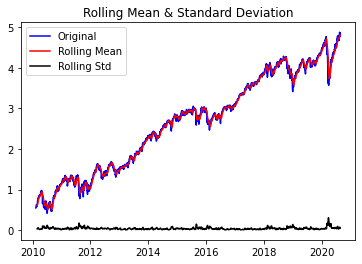

Results of Dickey-Fuller Test:
Test Statistic                   -0.282741
p-value                           0.927913
#Lags Used                       26.000000
Number of Observations Used    2618.000000
Critical Value (1%)              -3.432850
Critical Value (5%)              -2.862645
Critical Value (10%)             -2.567358
dtype: float64


In [262]:
# 정성적 그래프 분석
plot_rolling_statistics(df_TQQQ_Close_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(df_TQQQ_Close_log)

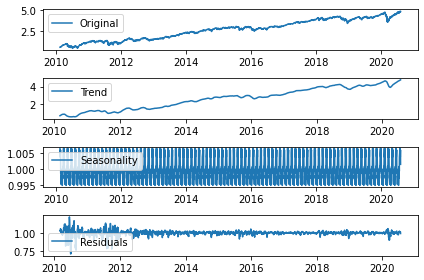

In [263]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_TQQQ_Close_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_TQQQ_Close_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

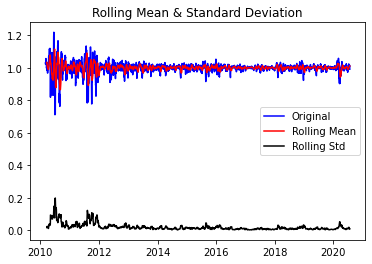

Results of Dickey-Fuller Test:
Test Statistic                -1.390859e+01
p-value                        5.563949e-26
#Lags Used                     2.800000e+01
Number of Observations Used    2.586000e+03
Critical Value (1%)           -3.432881e+00
Critical Value (5%)           -2.862658e+00
Critical Value (10%)          -2.567365e+00
dtype: float64


In [264]:
# Residual의 안정성 여부 확인

plot_rolling_statistics(residual)

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

 => p-value 값이 매우 작으므로 시계열 데이터가 안정적이라고 할 수 있음

# STEP 7 - STEP (4) : 학습, 테스트 데이터셋 생성(종목 2 : TQQQ)

     * 학습, 테스트 데이터셋 분리

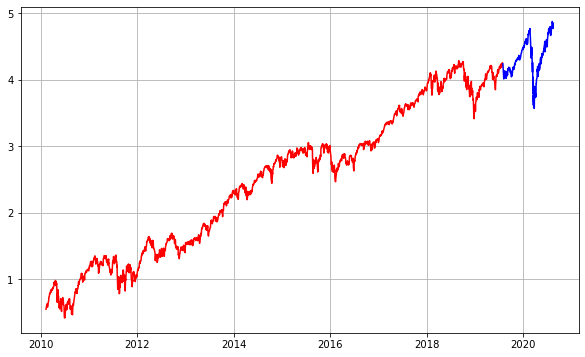

In [265]:
# 학습 데이터와 테스트 데이터 셋 분리

# 이후 Step에서 ARIMA를 사용하여 Trend와 Seasonality와 Residual로 Decompose를 수행할 것이므로
# 위에서 구한 Residual을 사용하지 않음

train_data, test_data = df_TQQQ_Close_log[:int(len(df_TQQQ_Close_log)*0.9)], df_TQQQ_Close_log[int(len(df_TQQQ_Close_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')

# STEP 7 - STEP (5) : 적정 ARIMA 모수 찾기(종목 2 : TQQQ)

 * ACF, PACF 그려보기 -> p,q 구하기
 * 차분 안정성 확인 -> d 구하기

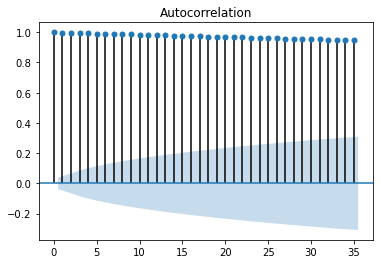

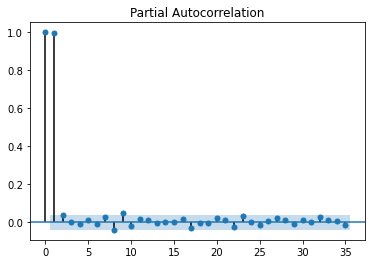

In [266]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF, PACF 그려보기
plot_acf(df_TQQQ_Close_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(df_TQQQ_Close_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.129114e+01
p-value                        1.378907e-20
#Lags Used                     2.500000e+01
Number of Observations Used    2.618000e+03
Critical Value (1%)           -3.432850e+00
Critical Value (5%)           -2.862645e+00
Critical Value (10%)          -2.567358e+00
dtype: float64


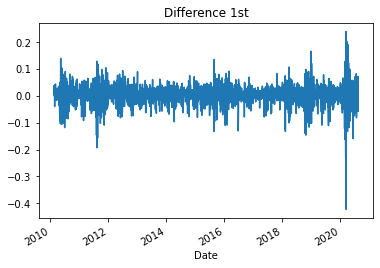

In [267]:
# 1차 차분 구하기
diff_1 = df_TQQQ_Close_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.595687e+01
p-value                        7.251627e-29
#Lags Used                     2.800000e+01
Number of Observations Used    2.614000e+03
Critical Value (1%)           -3.432854e+00
Critical Value (5%)           -2.862646e+00
Critical Value (10%)          -2.567359e+00
dtype: float64


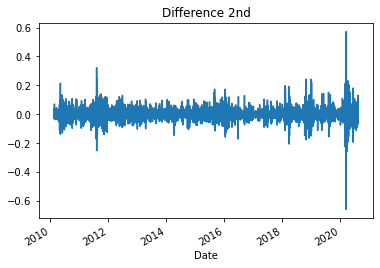

In [268]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

=> 1차, 2차 차분 모두 p-value가 0값 이므로 d=1로 선정

# STEP 7 - STEP (6) : ARIMA 모델 훈련과 테스트(종목 2 : TQQQ)
 * ARIMA 모델 빌드와 훈련
 * 모델 테스트 및 플로팅
 * 최종 예측 모델 정확도 측정(MAPE)

In [269]:
ARIMA??

In [270]:
from statsmodels.tsa.arima_model import ARIMA

# 모델 만들기
model = ARIMA(train_data, order=(1, 1, 0))  

# 모델 훈련
fitted_m = model.fit(disp=-1)  

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2379
Model:                 ARIMA(1, 1, 0)   Log Likelihood                4783.575
Method:                       css-mle   S.D. of innovations              0.032
Date:                Fri, 14 Aug 2020   AIC                          -9561.150
Time:                        18:09:02   BIC                          -9543.826
Sample:                             1   HQIC                         -9554.845
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0016      0.001      2.355      0.019       0.000       0.003
ar.L1.D.Close    -0.0055      0.021     -0.270      0.787      -0.046       0.035
                                    Root

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


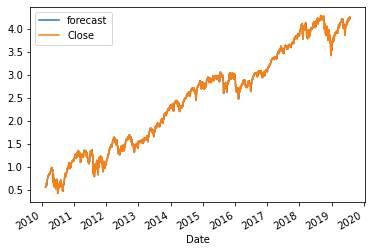

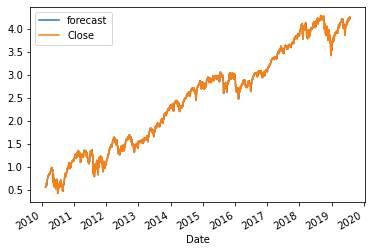

In [271]:
fitted_m.plot_predict()

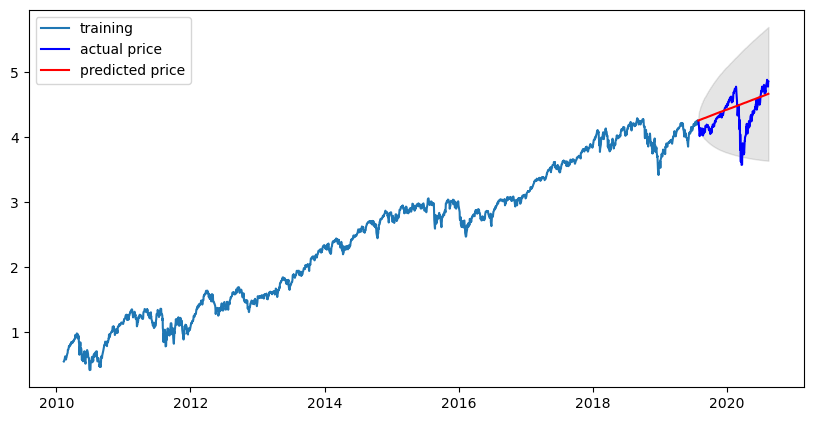

In [272]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [273]:
# 최종 예측 정확도 측정

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  373.24952826141975
MAE:  15.17798081637418
RMSE:  19.319666877599616
MAPE: 23.37%


# STEP 7 - step(1) 데이터 불러오기(종목 3 : SPY)

In [274]:
# 데이터 불어오기

# 파일 경로 저장
data_path_SPY = os.getenv("HOME") + "/aiffel/stock_prediction/data/SPY.csv"

# train.csv 파일을 DataFrame에 저장
# 'Date'열을 index로 변환시킴
# parse_dates=True : str자료형으로 저장된 날짜 데이터를 pandas의 
#    <class 'pandas._libs.tslibs.timestamps.Timestamp'> 자료형으로 변환
df_SPY = pd.read_csv(data_path_SPY, index_col='Date', parse_dates=True)
df_SPY.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,26.184059,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,26.370279,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,26.426161,201300
1993-02-03,44.40625,44.84375,44.37500,44.81250,26.705482,529400
1993-02-04,44.96875,45.09375,44.46875,45.00000,26.817228,531500


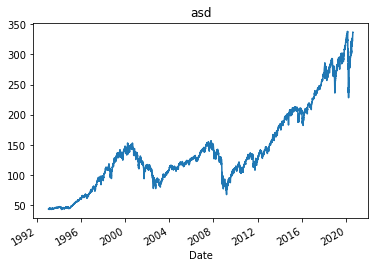

In [275]:
df_SPY.Open.plot(title = 'asd')

In [276]:
# Close(종가)만 따로 데이터 분리

df_SPY_Close = df_SPY['Close']
df_SPY_Close.head()

Date
1993-01-29    43.93750
1993-02-01    44.25000
1993-02-02    44.34375
1993-02-03    44.81250
1993-02-04    45.00000
Name: Close, dtype: float64

# STEP 7 - STEP (2) : 각종 전처리 수행(종목 3 : SPY)
     * 결측치 처리
     * 로그 변환

In [277]:
df_SPY_Close

Date
1993-01-29     43.937500
1993-02-01     44.250000
1993-02-02     44.343750
1993-02-03     44.812500
1993-02-04     45.000000
                 ...    
2020-08-07    334.570007
2020-08-10    335.570007
2020-08-11    332.799988
2020-08-12    337.440002
2020-08-13    336.829987
Name: Close, Length: 6936, dtype: float64

In [278]:
df_SPY_Close.isna()

Date
1993-01-29    False
1993-02-01    False
1993-02-02    False
1993-02-03    False
1993-02-04    False
              ...  
2020-08-07    False
2020-08-10    False
2020-08-11    False
2020-08-12    False
2020-08-13    False
Name: Close, Length: 6936, dtype: bool

In [279]:
# 결측치 처리
# Series[] 대괄호 안에 요소가 T/F로 이루어진 같은 크기의 serise를 넣으면, 
# True에 해당하는 요소 값 출력

df_SPY_Close=df_SPY_Close.interpolate(method='time')
# .interpolate(method='time') 위에 시계

df_SPY_Close[df_SPY_Close.isna()]   # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.
# interpolation 을 수행해서 결과로 NaN이 나오지 않음


Series([], Name: Close, dtype: float64)

In [280]:
# 로그 변환 시도

df_SPY_Close_log = np.log(df_SPY_Close)

# STEP 7 - STEP (3) : 시계열 안정성 분석(종목 3 : SPY)

 - 정성적 그래프 분석
 - 정량적 Augmented Dicky-Fuller Test
 - 시계열 분해(Time Series Decomposition)
 - Residual 안정성 확인



In [281]:
from statsmodels.tsa.stattools import adfuller

# 정성적 그래프 함수 선언
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

# 정량적 Augmented Dicky-Fuller Test 함수 선언    
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    

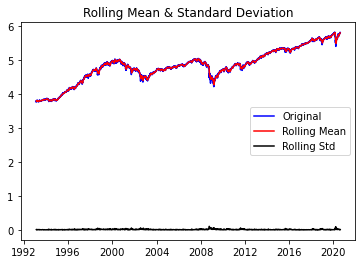

Results of Dickey-Fuller Test:
Test Statistic                   -0.937335
p-value                           0.775429
#Lags Used                       34.000000
Number of Observations Used    6901.000000
Critical Value (1%)              -3.431298
Critical Value (5%)              -2.861959
Critical Value (10%)             -2.566993
dtype: float64


In [282]:
# 정성적 그래프 분석
plot_rolling_statistics(df_SPY_Close_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(df_SPY_Close_log)

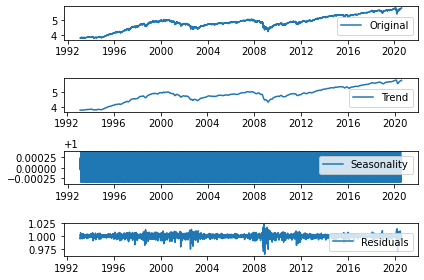

In [283]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_SPY_Close_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_SPY_Close_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

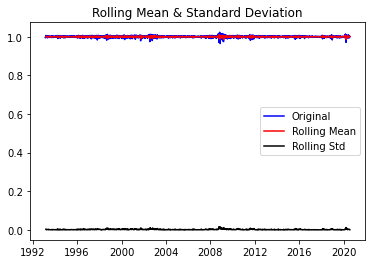

Results of Dickey-Fuller Test:
Test Statistic                  -19.761180
p-value                           0.000000
#Lags Used                       34.000000
Number of Observations Used    6871.000000
Critical Value (1%)              -3.431302
Critical Value (5%)              -2.861961
Critical Value (10%)             -2.566994
dtype: float64


In [284]:
# Residual의 안정성 여부 확인

plot_rolling_statistics(residual)

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

 => p-value 값이 매우 작으므로 시계열 데이터가 안정적이라고 할 수 있음

# STEP 7 - STEP (4) : 학습, 테스트 데이터셋 생성(종목 3 : SPY)

     * 학습, 테스트 데이터셋 분리

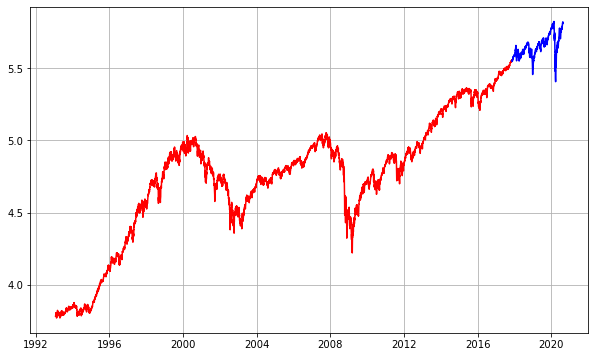

In [285]:
# 학습 데이터와 테스트 데이터 셋 분리

# 이후 Step에서 ARIMA를 사용하여 Trend와 Seasonality와 Residual로 Decompose를 수행할 것이므로
# 위에서 구한 Residual을 사용하지 않음

train_data, test_data = df_SPY_Close_log[:int(len(df_SPY_Close_log)*0.9)], df_SPY_Close_log[int(len(df_SPY_Close_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')

# STEP 7 - STEP (5) : 적정 ARIMA 모수 찾기(종목 3 : SPY)

 * ACF, PACF 그려보기 -> p,q 구하기
 * 차분 안정성 확인 -> d 구하기

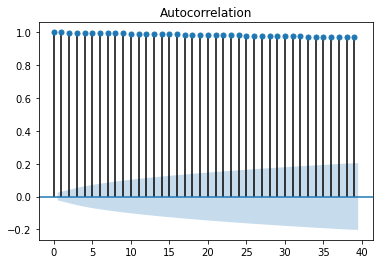

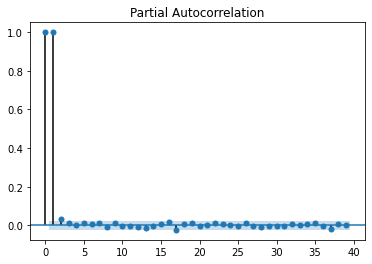

In [286]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF, PACF 그려보기
plot_acf(df_SPY_Close_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(df_SPY_Close_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.534649e+01
p-value                        3.769975e-28
#Lags Used                     3.300000e+01
Number of Observations Used    6.901000e+03
Critical Value (1%)           -3.431298e+00
Critical Value (5%)           -2.861959e+00
Critical Value (10%)          -2.566993e+00
dtype: float64


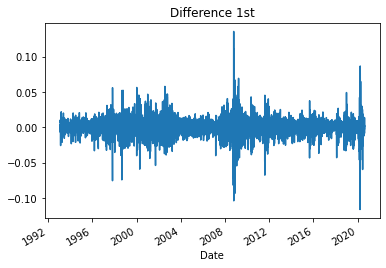

In [287]:
# 1차 차분 구하기
diff_1 = df_SPY_Close_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                  -23.618430
p-value                           0.000000
#Lags Used                       35.000000
Number of Observations Used    6898.000000
Critical Value (1%)              -3.431298
Critical Value (5%)              -2.861959
Critical Value (10%)             -2.566993
dtype: float64


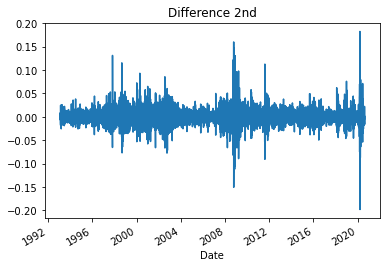

In [288]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

=> 1차, 2차 차분 모두 p-value가 0값 이므로 d=1로 선정

# STEP 7 - STEP (6) : ARIMA 모델 훈련과 테스트(종목 3 : SPY)
 * ARIMA 모델 빌드와 훈련
 * 모델 테스트 및 플로팅
 * 최종 예측 모델 정확도 측정(MAPE)

In [289]:
ARIMA??

In [290]:
from statsmodels.tsa.arima_model import ARIMA

# 모델 만들기
model = ARIMA(train_data, order=(1, 1, 0))  

# 모델 훈련
fitted_m = model.fit(disp=-1)  

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 6241
Model:                 ARIMA(1, 1, 0)   Log Likelihood               18964.631
Method:                       css-mle   S.D. of innovations              0.012
Date:                Fri, 14 Aug 2020   AIC                         -37923.261
Time:                        18:09:04   BIC                         -37903.045
Sample:                             1   HQIC                        -37916.254
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.000      2.057      0.040    1.34e-05       0.001
ar.L1.D.Close    -0.0617      0.013     -4.885      0.000      -0.086      -0.037
                                    Root

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


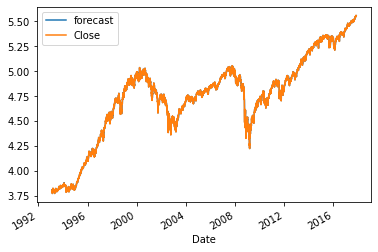

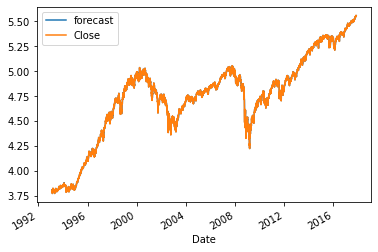

In [291]:
fitted_m.plot_predict()

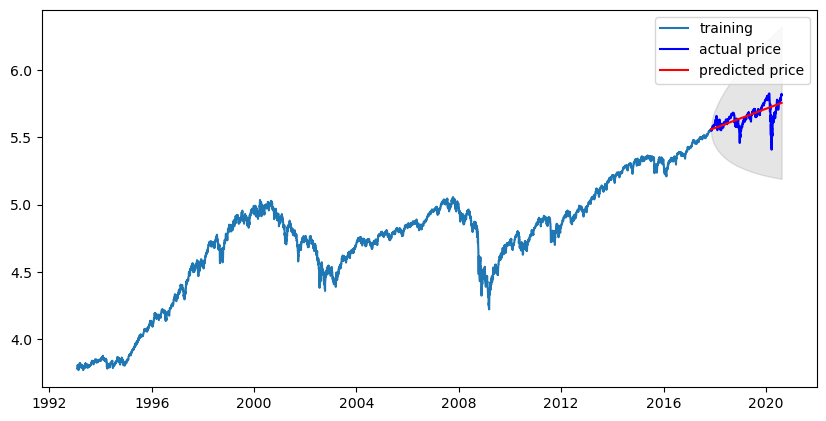

In [292]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [293]:
# 최종 예측 정확도 측정

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  257.4368283943878
MAE:  11.175713164046776
RMSE:  16.044838060709363
MAPE: 3.97%


# STEP 7 - step(1) 데이터 불러오기(종목 4 : GOOGLE)

In [295]:
# 데이터 불어오기

# 파일 경로 저장
data_path_GOOG = os.getenv("HOME") + "/aiffel/stock_prediction/data/GOOG.csv"

# train.csv 파일을 DataFrame에 저장
# 'Date'열을 index로 변환시킴
# parse_dates=True : str자료형으로 저장된 날짜 데이터를 pandas의 
#    <class 'pandas._libs.tslibs.timestamps.Timestamp'> 자료형으로 변환
df_GOOG = pd.read_csv(data_path_GOOG, index_col='Date', parse_dates=True)
df_GOOG.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100


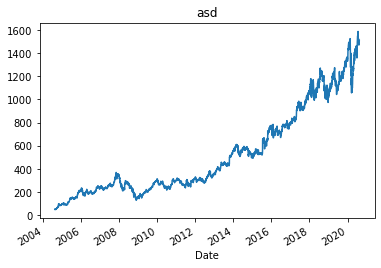

In [296]:
df_GOOG.Open.plot(title = 'asd')

In [297]:
# Close(종가)만 따로 데이터 분리

df_GOOG_Close = df_GOOG['Close']
df_GOOG_Close.head()

Date
2004-08-19    49.982655
2004-08-20    53.952770
2004-08-23    54.495735
2004-08-24    52.239193
2004-08-25    52.802086
Name: Close, dtype: float64

# STEP 7 - STEP (2) : 각종 전처리 수행(종목 4 : GOOGLE)
     * 결측치 처리
     * 로그 변환

In [298]:
df_GOOG_Close

Date
2004-08-19      49.982655
2004-08-20      53.952770
2004-08-23      54.495735
2004-08-24      52.239193
2004-08-25      52.802086
                 ...     
2020-08-07    1494.489990
2020-08-10    1496.099976
2020-08-11    1480.319946
2020-08-12    1506.619995
2020-08-13    1518.449951
Name: Close, Length: 4025, dtype: float64

In [299]:
df_GOOG_Close.isna()

Date
2004-08-19    False
2004-08-20    False
2004-08-23    False
2004-08-24    False
2004-08-25    False
              ...  
2020-08-07    False
2020-08-10    False
2020-08-11    False
2020-08-12    False
2020-08-13    False
Name: Close, Length: 4025, dtype: bool

In [300]:
# 결측치 처리
# Series[] 대괄호 안에 요소가 T/F로 이루어진 같은 크기의 serise를 넣으면, 
# True에 해당하는 요소 값 출력

df_GOOG_Close=df_GOOG_Close.interpolate(method='time')
# .interpolate(method='time') 위에 시계

df_GOOG_Close[df_GOOG_Close.isna()]   # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.
# interpolation 을 수행해서 결과로 NaN이 나오지 않음


Series([], Name: Close, dtype: float64)

In [301]:
# 로그 변환 시도

df_GOOG_Close_log = np.log(df_GOOG_Close)

# STEP 7 - STEP (3) : 시계열 안정성 분석(종목 4 : GOOGLE)

 - 정성적 그래프 분석
 - 정량적 Augmented Dicky-Fuller Test
 - 시계열 분해(Time Series Decomposition)
 - Residual 안정성 확인



In [302]:
from statsmodels.tsa.stattools import adfuller

# 정성적 그래프 함수 선언
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

# 정량적 Augmented Dicky-Fuller Test 함수 선언    
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    

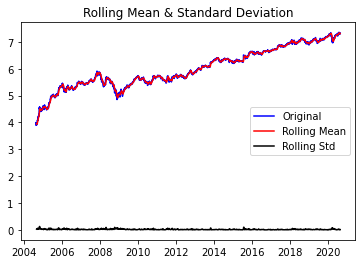

Results of Dickey-Fuller Test:
Test Statistic                   -2.283112
p-value                           0.177473
#Lags Used                       12.000000
Number of Observations Used    4012.000000
Critical Value (1%)              -3.431981
Critical Value (5%)              -2.862261
Critical Value (10%)             -2.567154
dtype: float64


In [303]:
# 정성적 그래프 분석
plot_rolling_statistics(df_GOOG_Close_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(df_GOOG_Close_log)

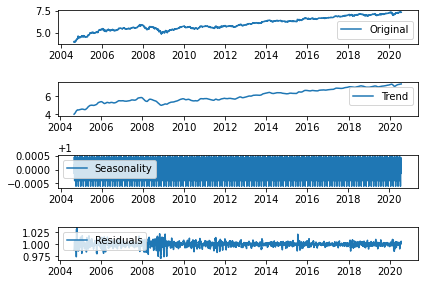

In [304]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_GOOG_Close_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_GOOG_Close_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

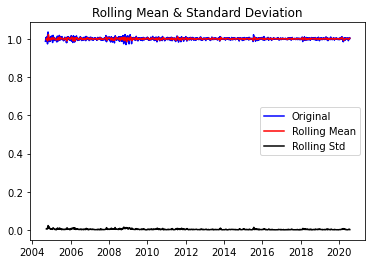

Results of Dickey-Fuller Test:
Test Statistic                -1.466132e+01
p-value                        3.377907e-27
#Lags Used                     3.000000e+01
Number of Observations Used    3.964000e+03
Critical Value (1%)           -3.432001e+00
Critical Value (5%)           -2.862269e+00
Critical Value (10%)          -2.567158e+00
dtype: float64


In [305]:
# Residual의 안정성 여부 확인

plot_rolling_statistics(residual)

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

 => p-value 값이 매우 작으므로 시계열 데이터가 안정적이라고 할 수 있음

# STEP 7 - STEP (4) : 학습, 테스트 데이터셋 생성(종목 4 : GOOGLE)

     * 학습, 테스트 데이터셋 분리

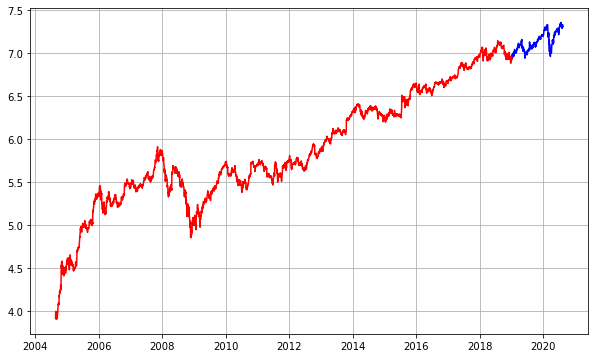

In [306]:
# 학습 데이터와 테스트 데이터 셋 분리

# 이후 Step에서 ARIMA를 사용하여 Trend와 Seasonality와 Residual로 Decompose를 수행할 것이므로
# 위에서 구한 Residual을 사용하지 않음

train_data, test_data = df_GOOG_Close_log[:int(len(df_GOOG_Close_log)*0.9)], df_GOOG_Close_log[int(len(df_GOOG_Close_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')

# STEP 7 - STEP (5) : 적정 ARIMA 모수 찾기(종목 4 : GOOGLE)

 * ACF, PACF 그려보기 -> p,q 구하기
 * 차분 안정성 확인 -> d 구하기

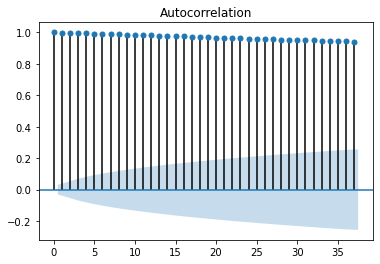

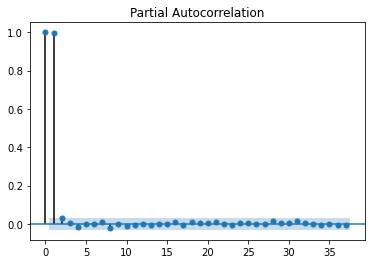

In [307]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF, PACF 그려보기
plot_acf(df_GOOG_Close_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(df_GOOG_Close_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.761399e+01
p-value                        3.867347e-30
#Lags Used                     1.100000e+01
Number of Observations Used    4.012000e+03
Critical Value (1%)           -3.431981e+00
Critical Value (5%)           -2.862261e+00
Critical Value (10%)          -2.567154e+00
dtype: float64


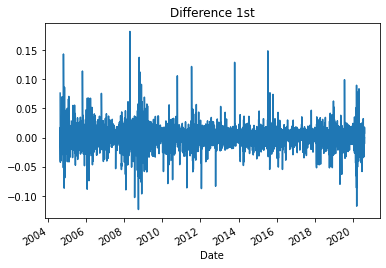

In [308]:
# 1차 차분 구하기
diff_1 = df_GOOG_Close_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                  -20.249464
p-value                           0.000000
#Lags Used                       31.000000
Number of Observations Used    3991.000000
Critical Value (1%)              -3.431990
Critical Value (5%)              -2.862264
Critical Value (10%)             -2.567156
dtype: float64


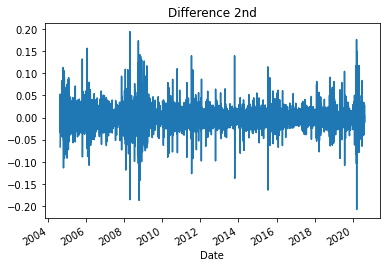

In [309]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

=> 1차, 2차 차분 모두 p-value가 0값 이므로 d=1로 선정

# STEP 7 - STEP (6) : ARIMA 모델 훈련과 테스트(종목 4 : GOOGLE)
 * ARIMA 모델 빌드와 훈련
 * 모델 테스트 및 플로팅
 * 최종 예측 모델 정확도 측정(MAPE)


In [310]:
from statsmodels.tsa.arima_model import ARIMA

# 모델 만들기
model = ARIMA(train_data, order=(1, 1, 0))  

# 모델 훈련
fitted_m = model.fit(disp=-1)  

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3621
Model:                 ARIMA(1, 1, 0)   Log Likelihood                9214.034
Method:                       css-mle   S.D. of innovations              0.019
Date:                Fri, 14 Aug 2020   AIC                         -18422.068
Time:                        18:09:39   BIC                         -18403.484
Sample:                             1   HQIC                        -18415.447
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      2.663      0.008       0.000       0.001
ar.L1.D.Close     0.0087      0.017      0.521      0.602      -0.024       0.041
                                    Root

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


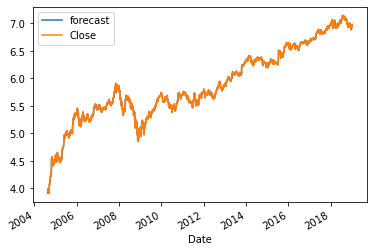

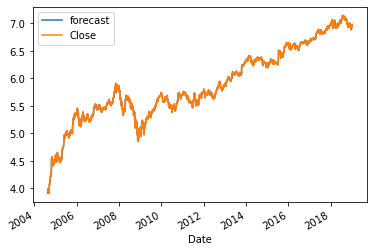

In [311]:
fitted_m.plot_predict()

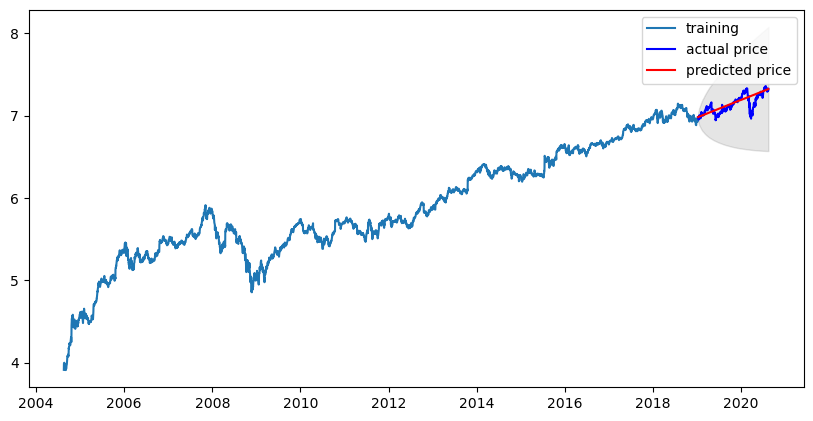

In [312]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [313]:
# 최종 예측 정확도 측정

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  7980.9172365756185
MAE:  63.38708575838924
RMSE:  89.33597951875615
MAPE: 5.14%


# 프로젝트 수행 간 로그

 * 프로젝트를 수행하며, 결측치 처리 단계에서, 아래와 에러가 발생하였습니다.
   ValueError: time-weighted interpolation only works on Series or DataFrames with a DatetimeIndex
   
 * 원인을 분석해본 결과, 데이터 파일인 .csv 파일을 불러오는 과정에서 index_col='Date', parse_dates=True 옵션 설정 과정을
   생략하고 진행하였는데, 이 때문에 보간하려는 데이터가 날짜에 대한 index 설정이 되어있지 않아 time에 대하여 interpolation이 
   수행되지 않아서 발생한 에러였습니다. 
   => 조원들과 논의하며 원인을 확인하였고, 내용 수정하여 정상 진행하였습니다.
 

# 프로젝트 결과 및 느낀점

 * 첫번째 종목인 QQQ의 경우, 최종 MAPE는 7.12%로 예제였던 삼성전자의 MAPE이 8.77% 인 것에 비하여 예측 결과가 더 잘 나왔습니다.
 * 이처럼 결과 예측이 잘 된 이유는 QQQ 종목의 경우 나스닥 종합주가 지수를 추종하므로, 하나의 기업이 아닌 여러 기업들의 경제적 가치를
   종합적으로 따르므로, 시간 외적인 요인에서 영향을 덜 받기 때문이라고 생각합니다.
   
 * 두 번째 종목인 TQQQ의 경우 MAPE 값이 크게 나왔는데, 이 이유는 동일하게 종합주가 지수를 따르지만, x3 레버리지로서 큰 변동 폭을 같기 때문에 안정적인 시계열 데이터가 아니었던 것으로 판단 됩니다.
 
 * 세 번째 종목인 SPY 역시, 안정적인 기업 500곳의 종합주가를 따르므로 주가가 안정적인 시계열 데이터인 것으로 판단됩니다. 이에 따라 MAPE 값이 3.97%로 매우 낮게 잘 나왔습니다.
 
 * 네 번째 종목인 구글의 경우도, 오랜기간 동안 안정적으로 성장해 온 대기업 중 대표적인 곳인 만큼, 주가가 안정적인 시계열을 이루는 것으로 판단되며, 이에따라 MAPE 값이 낮게 잘 나왔습니다.
   
 * 프로젝트를 수행하면서 어려웠던 점으로는 이번 프로젝트에서 통계적 지식을 필요로 하는 기법이 많이 사용되었는데, 
   그 기법에 대한 개념이 완전 생소하다보니 이해하는데 시간이 많이 소요되었습니다.
   
 * 또 다른 느낀점으로는 주가의 경우, 시계열 경향도 있지만, 시간적 요소 외적인 요소들에 대하여 영향을 많이 받기 때문에,
   시계열 기법이 아닌 딥러닝 혹은 머신러닝 기법을 이용하여, 시간 외적인 요소들에 대하여 특징을 설정하고, 그에 맞는 모델을
   설계한다면 좀 더 좋은 예측 모델을 얻을 수 있을 것으로 생각됩니다.
